### IMPORT LIBRARIES

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

### LOAD AND TRANSFORM DATA AND DEFINE DATA LOADER

In [2]:
data_dir = 'C:/Users/admin/Desktop/1.TOTORIAL/PRACTICE new/projects/pytorch_project/satalite'

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

#define Pytorch data loader
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

load a model such as [DenseNet](http://pytorch.org/docs/0.3.0/torchvision/models.html#id5)

In [3]:
#print out the model architecture
model = models.densenet121(pretrained=True)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

#### PLOT SOME IMAGES

Found 5631 files belonging to 4 classes.


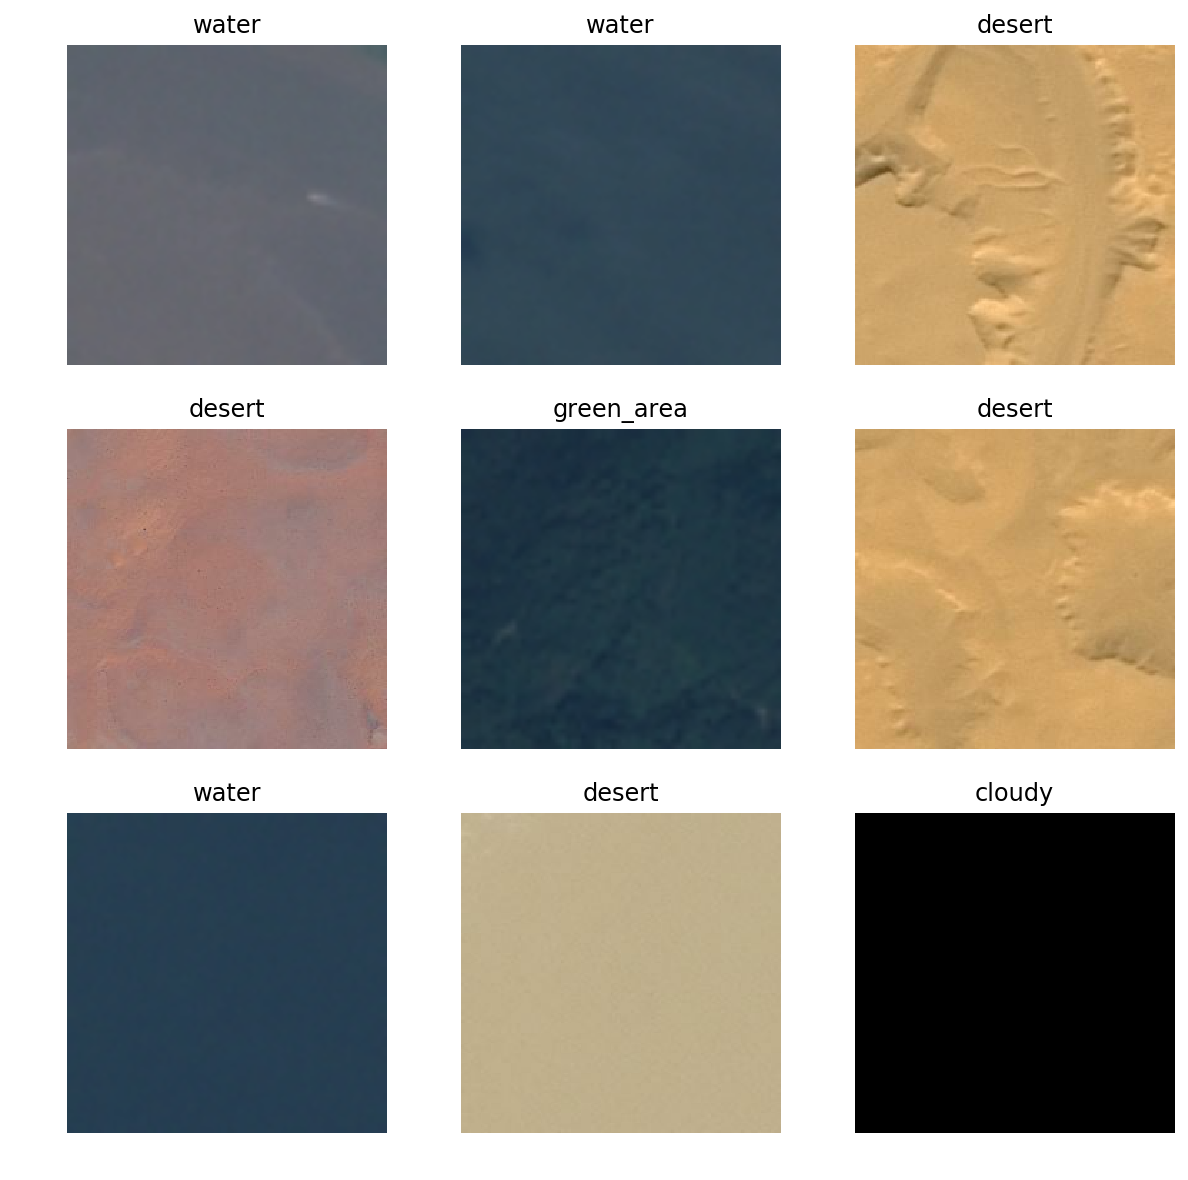

In [6]:
from tensorflow.keras.preprocessing import image_dataset_from_directory  

train_dataset = image_dataset_from_directory('C:/Users/admin/Desktop/1.TOTORIAL/PRACTICE new/projects/pytorch_project/satalite/train',
                                             shuffle=True,
                                             batch_size=32,image_size=(224,224))
class_name =  train_dataset.class_names
plt.figure(figsize = (10,10))
for image , label in train_dataset.take(1):
    for i in range(9) :
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_name[label[i]])
        plt.axis("off")

### PYTORCH uses cuda library as gpu for training but my laptop doesnt have a cuda enabled gpu

#### check cpu speed (optional)

In [5]:
import time

In [6]:
# Try to replace with just ['cuda'] if you are using GPU 

for device in ['cpu']:

    criterion = nn.NLLLoss()
    # Only train the classifier parameters, feature parameters are frozen
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

    model.to(device)

    for ii, (inputs, labels) in enumerate(trainloader):

        # Move input and label tensors to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        start = time.time()

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        #backward propagation
        loss.backward()
        optimizer.step()

        if ii==3:
            break
        
    print(f"Device = {device}; Time per batch: {(time.time() - start)/3:.3f} seconds")

Device = cpu; Time per batch: 7.747 seconds


### NEURAL NETWORK

In [59]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

#DEFINE NEURAL NETWORK

model.classifier = nn.Sequential(nn.Linear(1024, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.1),
                                 nn.Linear(256, 4),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device);

### TRAIN STEPS

In [60]:
traininglosses = []
testinglosses = []
testaccuracy = []
totalsteps = []
epochs = 1
steps = 0
running_loss = 0
print_every = 5
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        #backward propagation and optimizer step to update the weights
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            traininglosses.append(running_loss/print_every)
            testinglosses.append(test_loss/len(testloader))
            testaccuracy.append(accuracy/len(testloader))
            totalsteps.append(steps)
            print(f"Device {device}.."
                  f"Epoch {epoch+1}/{epochs}.. "
                  f"Step {steps}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

Device cpu..Epoch 1/1.. Step 5.. Train loss: 1.134.. Test loss: 0.944.. Test accuracy: 0.684
Device cpu..Epoch 1/1.. Step 10.. Train loss: 0.777.. Test loss: 0.828.. Test accuracy: 0.727
Device cpu..Epoch 1/1.. Step 15.. Train loss: 0.681.. Test loss: 0.476.. Test accuracy: 0.836
Device cpu..Epoch 1/1.. Step 20.. Train loss: 0.379.. Test loss: 0.489.. Test accuracy: 0.773
Device cpu..Epoch 1/1.. Step 25.. Train loss: 0.245.. Test loss: 0.189.. Test accuracy: 0.977
Device cpu..Epoch 1/1.. Step 30.. Train loss: 0.195.. Test loss: 0.247.. Test accuracy: 0.875
Device cpu..Epoch 1/1.. Step 35.. Train loss: 0.162.. Test loss: 0.049.. Test accuracy: 0.980
Device cpu..Epoch 1/1.. Step 40.. Train loss: 0.167.. Test loss: 0.073.. Test accuracy: 0.977
Device cpu..Epoch 1/1.. Step 45.. Train loss: 0.253.. Test loss: 0.041.. Test accuracy: 0.984
Device cpu..Epoch 1/1.. Step 50.. Train loss: 0.321.. Test loss: 0.059.. Test accuracy: 0.973
Device cpu..Epoch 1/1.. Step 55.. Train loss: 0.144.. Test lo

### PLOT TRAINING STEP GRAPH

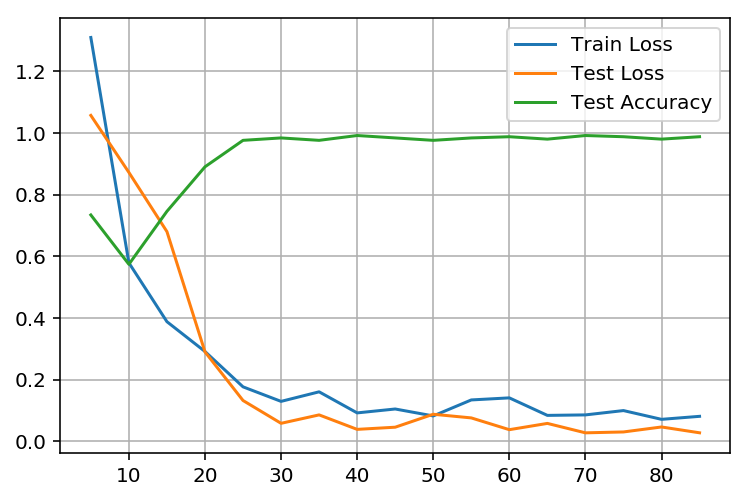

In [24]:
from matplotlib import pyplot as plt
plt.plot(totalsteps, traininglosses, label='Train Loss')
plt.plot(totalsteps, testinglosses, label='Test Loss')
plt.plot(totalsteps, testaccuracy, label='Test Accuracy')
plt.legend()
plt.grid()
plt.show()

### SAVE TRAINED MODEL

In [61]:
torch.save(model, 'newsatmodel.pth')

### USE TRAINED MODEL FOR PREDICTION

In [72]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

#load model

model2 = torch.load('./newsatmodel.pth')

### to predict

In [92]:
#link to test data
data_dir = 'C:/Users/admin/Desktop/1.TOTORIAL/PRACTICE new/projects/pytorch_project/satalite/test'
#transform image data
test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                     ])

model=model2

In [93]:
#function to predict an image
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = image_tensor

    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [94]:
#random shuffle
import numpy as np
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

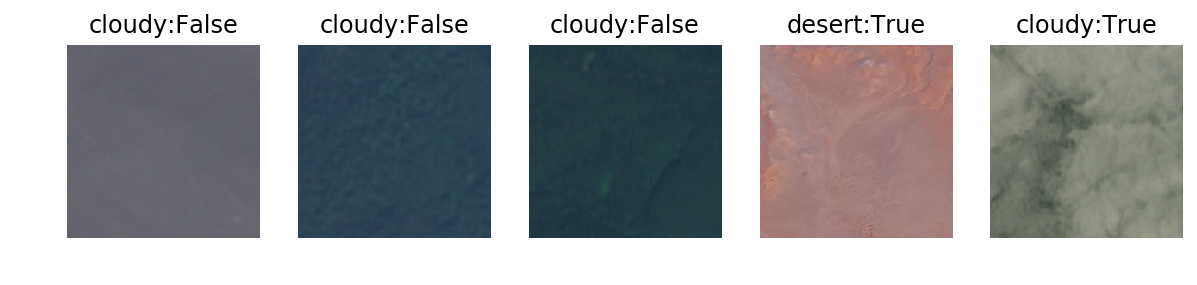

In [95]:
#use the model in prediction

to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()